In [1]:
# パッケージのimport
import random
import math
import time
import glob
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


In [3]:
class Generator(nn.Module):

    def __init__(self, z_dim=100, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 3, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


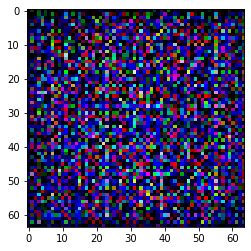

In [6]:
# 動作
G = Generator(z_dim=100, image_size=64)

# 入力する乱数
input_z = torch.randn(1, 100)

# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images = G(input_z)

img_transformed = fake_images[0,:,:,:].detach().numpy().transpose(1,2,0)
plt.imshow(img_transformed, 'gray')
plt.show()

In [9]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=100, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


In [10]:
# 動作確認
D = Discriminator(z_dim=100, image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 100)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 偽画像をDに入力
d_out = D(fake_images)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))


tensor([[[[0.4946]]]], grad_fn=<SigmoidBackward>)


In [18]:
class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [19]:
class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed


In [22]:
# DataLoaderの作成と動作確認

# ファイルリストを作成
train_img_list = glob.glob('anime/*png')

# Datasetを作成
mean = (0.5,0.5, 0.5)
std = (0.5, 0.5, 0.5)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
images = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([64, 1, 64, 64])

torch.Size([64, 3, 64, 64])


In [28]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")


ネットワークの初期化完了


In [29]:
# モデルを学習させる関数を作成


def train_model(G, D, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 100
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D


In [68]:
# 学習・検証を実行する
# 6分ほどかかる
num_epochs = 3
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 0/3
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:23.1093 ||Epoch_G_Loss:590.5921
timer:  37.5729 sec.
-------------
Epoch 1/3
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:18.3912 ||Epoch_G_Loss:666.7309
timer:  37.4270 sec.
-------------
Epoch 2/3
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:33.8760 ||Epoch_G_Loss:600.2017
timer:  36.6272 sec.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


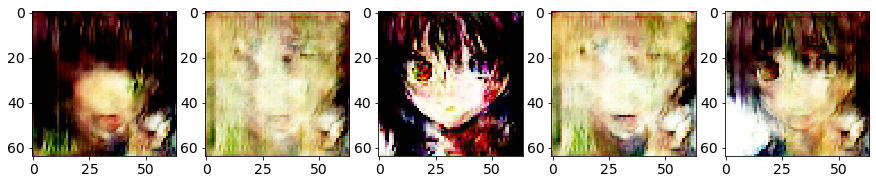

In [69]:
# 生成画像と訓練データを可視化する
# 本セルは良い感じの画像が生成されるまで、何度も実行し直しています。

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 64
z_dim = 100
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 3))
for i in range(0, 5):
    # 下段に生成データを表示する
    plt.subplot(1, 5, i+1)
    plt.imshow(fake_images[i].cpu().detach().numpy().transpose(1, 2, 0))

In [43]:
df = pd.read_csv('result/log_output.csv', index_col=0)

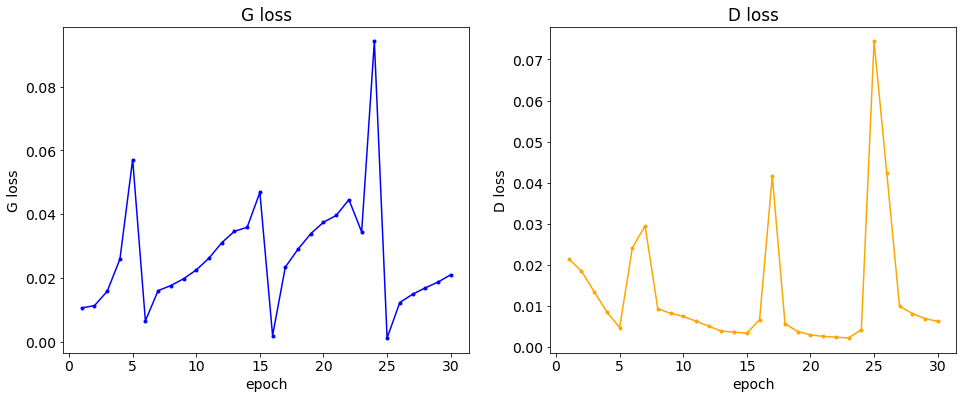

In [66]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.plot(df['epoch'], df['g_loss'], '.-', c='b',label='G')
ax.set_xlabel('epoch', fontsize=14)
ax.set_ylabel('G loss', fontsize=14)
ax.set_title('G loss')

ax = fig.add_subplot(122)
ax.plot(df['epoch'], df['d_loss'], '.-', c='orange',label='D')
ax.set_xlabel('epoch', fontsize=14)
ax.set_ylabel('D loss', fontsize=14)
ax.set_title('D loss')

plt.show()

In [70]:
steps = 10

start_input = torch.randn(batch_size, z_dim).view(batch_size, z_dim, 1, 1).to(device)

end_input =  torch.randn(batch_size, z_dim).view(batch_size, z_dim, 1, 1).to(device)

start_img = G_update(start_input)
end_img = G_update(end_input)

vectors = []

alpha_values = np.linspace(0, 1, steps)
for alpha in alpha_values:
    vector = start_input * (1 - alpha) + end_input * alpha
    vectors.append(vector)

vectors = np.array(vectors)

imgs = []
for i, vec in enumerate(vectors):
    gen_img = G_update(vec)
    imgs.append(gen_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


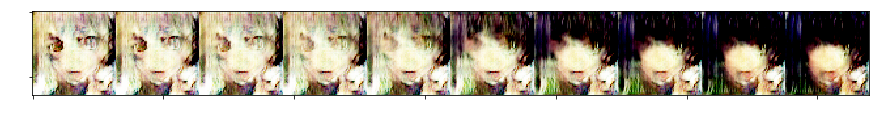

In [93]:
import cv2
concat_imgs = []
for i in range(len(imgs)):
    concat_imgs.append(imgs[i][16].cpu().detach().numpy().transpose(1, 2, 0))
    
fig = plt.figure(figsize=(15,5))
plt.imshow(cv2.hconcat(concat_imgs), 'gray')
plt.xticks(color="None")
plt.yticks(color="None")
plt.show()